# Forecasting Assignment
## CocaCola Sales

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import numpy as np

In [6]:
data = pd.read_excel('CocaCola_Sales_Rawdata.xlsx')
data.head()

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996


Plotting Sales\
We can see linear upward trend

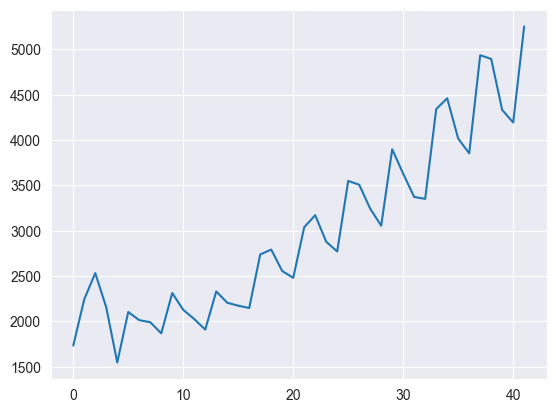

In [7]:
plt.plot(data['Sales'])

Making new variables Year and Quarter extracting from Quarter column

In [8]:
data['Year'] = data['Quarter'].str[-2:]
data['Quarter'] = data['Quarter'].str[:2]

In [9]:
data['t'] = data.index+1
data['t_square'] = data['t']**2
data['log_sales'] = np.log(data['Sales'])
data = pd.get_dummies(data=data, columns=['Quarter'])

In [10]:
data.head()

,Sales,Year,t,t_square,log_sales,Quarter_Q1,Quarter_Q2,Quarter_Q3,Quarter_Q4
0,1734.827000,86,1,1,7.458663,1,0,0,0
1,2244.960999,86,2,4,7.716443,0,1,0,0
2,2533.804993,86,3,9,7.837477,0,0,1,0
3,2154.962997,86,4,16,7.675529,0,0,0,1
4,1547.818996,87,5,25,7.344602,1,0,0,0


<Axes: xlabel='Year', ylabel='Sales'>

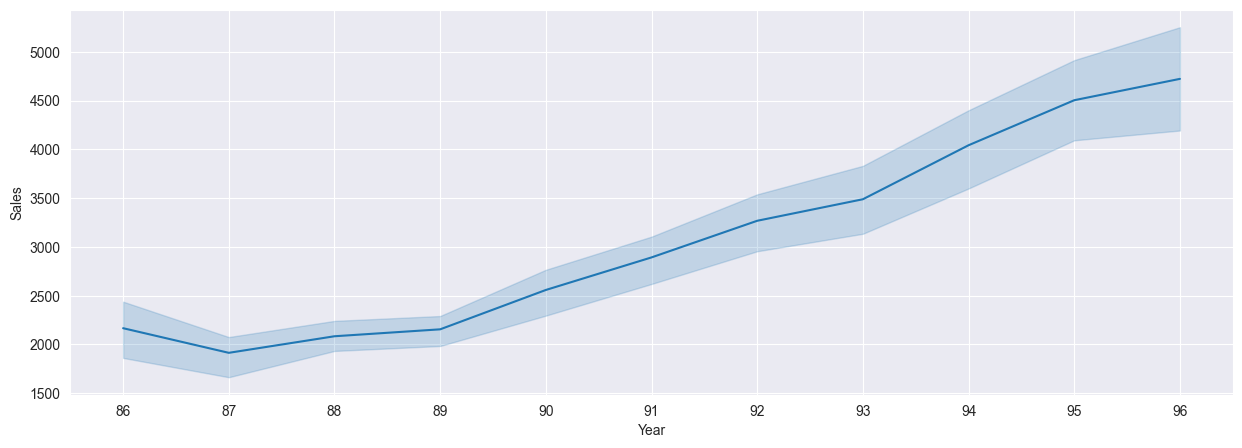

In [11]:
plt.figure(figsize=(15,5))
sns.lineplot(data=data,x='Year',y='Sales')

### Splitting the data

In [12]:
data.shape

(42, 9)

In [13]:
train = data.iloc[:30]
test = data.iloc[30:]

### Building Models

##### Linear Model

In [14]:
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error

linear_model = smf.ols('Sales~t', data=train).fit()
pred_linear = linear_model.predict(test['t'])
rmse_linear = np.sqrt(mean_squared_error(test['Sales'],pred_linear))
print('rmse for linear model is',rmse_linear)

rmse for linear model is 714.0144483281299


##### Exponential Model

In [15]:
exp_model = smf.ols('log_sales~t', data=train).fit()
pred_exp = exp_model.predict(test['t'])
rmse_exp = np.sqrt(mean_squared_error(test['log_sales'],pred_exp))
print('rmse for exponential model',rmse_exp)

rmse for exponential model 0.12733341664175737


##### Quadratic Model

In [16]:
quad_model = smf.ols('Sales~t+t_square', data=train).fit()
pred_quad = quad_model.predict(test[['t','t_square']])
rmse_quad = np.sqrt(mean_squared_error(test['Sales'],pred_quad))
print('rmse for quadratic model is',rmse_quad)

rmse for quadratic model is 646.2715428311304


##### Additive Seasonality Model

In [17]:
add_sea = smf.ols('Sales~Quarter_Q1+Quarter_Q2+Quarter_Q3+Quarter_Q4', data=train).fit()
pred_add_sea = add_sea.predict(test[['Quarter_Q1','Quarter_Q2','Quarter_Q3','Quarter_Q4']])
rmse_add_sea = np.sqrt(mean_squared_error(test['Sales'],pred_add_sea))
print('rmse for additive seasonality model is',rmse_add_sea)

rmse for additive seasonality model is 1778.0065467941365


##### Additive Seasonality Quadratic Model

In [18]:
add_sea_quad_model = smf.ols('Sales~t+t_square+Quarter_Q1+Quarter_Q2+Quarter_Q3+Quarter_Q4', data=train).fit()
pred_add_sea_quad = add_sea_quad_model.predict(test[['t','t_square','Quarter_Q1','Quarter_Q2','Quarter_Q3','Quarter_Q4']])
rmse_add_sea_quad = np.sqrt(mean_squared_error(test['Sales'],pred_add_sea_quad))
print('rmse for additive seasonality quadratic model is',rmse_add_sea_quad)

rmse for additive seasonality quadratic model is 586.0533067871002


##### Multiplicative Seasonality

In [19]:
mult_sea_model = smf.ols('log_sales~Quarter_Q1+Quarter_Q2+Quarter_Q3+Quarter_Q4', data=train).fit()
pred_mult_sea = mult_sea_model.predict(test[['Quarter_Q1','Quarter_Q2','Quarter_Q3','Quarter_Q4']])
rmse_mult_sea = np.sqrt(mean_squared_error(test['log_sales'],pred_mult_sea))
print('rmse for multiplicative seasonality model is',rmse_mult_sea)

rmse for multiplicative seasonality model is 0.547351038173912


### Comparing Results

In [20]:
result_data = pd.DataFrame({'Model':['linear','exponential','quadratic','add_sea','add_sea_quad','mul_sea'],
                            'RMSE_values':[rmse_linear,rmse_exp,rmse_quad,rmse_add_sea,rmse_add_sea_quad,rmse_mult_sea]})
result_data.sort_values('RMSE_values')

,Model,RMSE_values
1,exponential,0.127333
5,mul_sea,0.547351
4,add_sea_quad,586.053307
2,quadratic,646.271543
0,linear,714.014448
3,add_sea,1778.006547


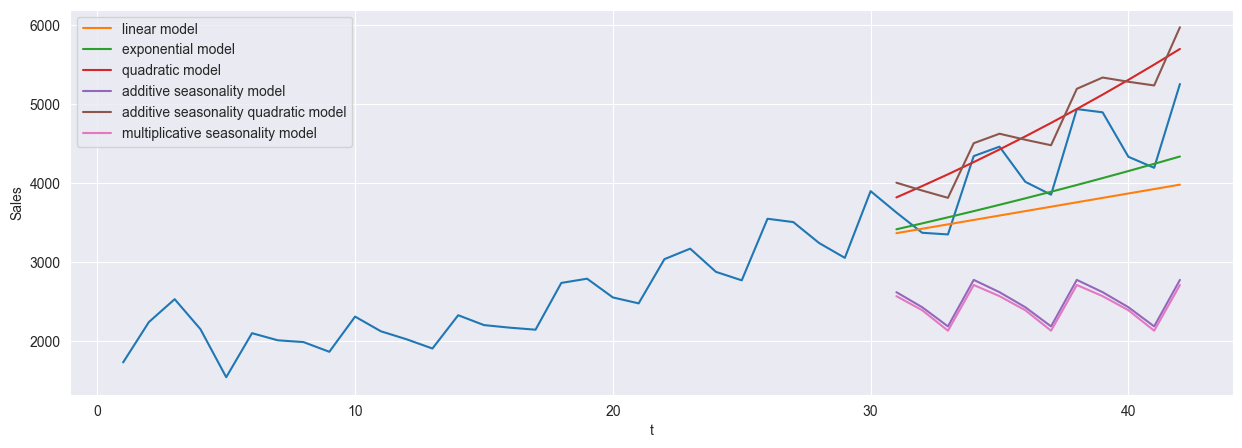

In [21]:
plt.figure(figsize=(15,5))
sns.lineplot(data=data, x='t', y='Sales')
sns.lineplot(x=test['t'], y=pred_linear, label='linear model')
sns.lineplot(x=test['t'], y=np.exp(pred_exp), label='exponential model')
sns.lineplot(x=test['t'], y=pred_quad, label='quadratic model')
sns.lineplot(x=test['t'], y=pred_add_sea, label='additive seasonality model')
sns.lineplot(x=test['t'], y=pred_add_sea_quad, label='additive seasonality quadratic model')
sns.lineplot(x=test['t'], y=np.exp(pred_mult_sea), label='multiplicative seasonality model')
plt.legend()

### ARIMA model

Checking data\
p>0.05 --> Non-stationary\
p<0.05 --> Stationary

In [22]:
from statsmodels.tsa.stattools import adfuller

def ad_test(dataset):
    dftest = adfuller(dataset,autolag='AIC')
    print("p-value: ",dftest[1])

ad_test(data['Sales'])

p-value:  0.9966611673930905


ARIMA model is specified by 3 order parameters: (p,d,q)\
p: AR(Auto Regression), d: I(Integration), q: MA(Moving Average)\
We will use auto_arima to find optimal values of (p,d,q)

In [27]:
from pmdarima import auto_arima

stepwise_fit = auto_arima(data['Sales'],
                          start_p=1, start_q=1, max_p=3, max_q=3,
                          m=12, start_P=0, seasonal=True, d=None, D=1, trace=True,
                          error_action='ignore', suppress_warnings=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=407.084, Time=0.55 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=402.446, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=406.443, Time=0.16 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=406.440, Time=0.19 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=404.444, Time=0.21 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=404.444, Time=0.18 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.34 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=404.445, Time=0.04 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=404.443, Time=0.06 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=405.084, Time=0.13 sec
 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=403.610, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,1,0)[12]          
Total fit time: 1.915 seconds


In [28]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   42
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -200.223
Date:                            Tue, 25 Apr 2023   AIC                            402.446
Time:                                    22:43:29   BIC                            403.813
Sample:                                         0   HQIC                           402.874
                                             - 42                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      5.813e+04   1.67e+04      3.472      0.001    2.53e+04    9.09e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 0.54
Prob(Q):                              0.88   Prob(JB):                         0.76
Heteroskedasticity (H):               0.54   Skew:                             0.22
Prob(H) (two-sided):                  0.35   Kurtosis:                         2.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

We are using SARIMAX model\
SARIMAX: Seasonal ARIMA with exogenous variables\
using best order obtained from auto_arima

In [29]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
  
arima_model = SARIMAX(train['Sales'],order=(0,1,0),seasonal_order=(0,1,0,12))
  
arima_model = arima_model.fit()
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Sales   No. Observations:                   30
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -118.553
Date:                            Tue, 25 Apr 2023   AIC                            239.106
Time:                                    22:46:47   BIC                            239.940
Sample:                                         0   HQIC                           239.189
                                             - 30                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      6.663e+04   2.56e+04      2.603      0.009    1.65e+04    1.17e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.32
Prob(Q):                              0.94   Prob(JB):                         0.85
Heteroskedasticity (H):               0.42   Skew:                             0.15
Prob(H) (two-sided):                  0.32   Kurtosis:                         2.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [30]:
start = len(train)
end = len(train)+len(test)-1
print(start,end)

30 41


In [31]:
pred_arima = arima_model.predict(start=start, end=end)
pred_arima

30    3952.445999
31    3715.701996
32    3640.666000
33    4199.214996
34    4331.807999
35    4038.693001
36    3931.692001
37    4709.692001
38    4667.692001
39    4403.551994
40    4215.692001
41    5058.692001
Name: predicted_mean, dtype: float64

In [32]:
rmse_arima = np.sqrt(mean_squared_error(pred_arima,test['Sales']))
print('rmse for ARIMA model is',rmse_arima)

rmse for ARIMA model is 203.11383458647384


<Axes: ylabel='Sales'>

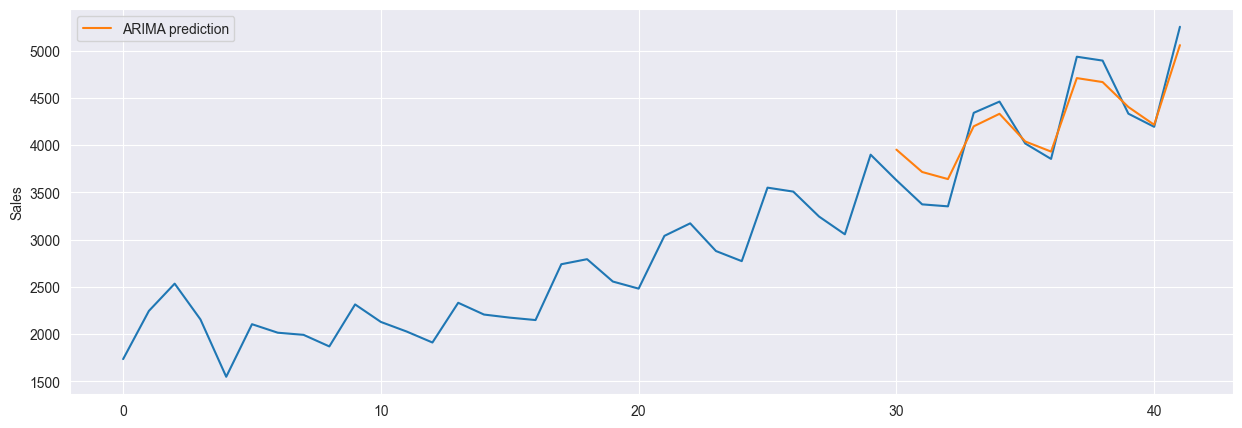

In [34]:
plt.figure(figsize=(15,5))
sns.lineplot(data['Sales'])
sns.lineplot(pred_arima, label='ARIMA prediction')